In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random
random.seed(42)

%matplotlib inline

In [8]:
def get_image_intensity_histogram(file_location):
    image = cv2.imread(file_location)
    resized_image = cv2.resize(image, (200, 200), interpolation = cv2.INTER_AREA)
    gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    
    # perform histogram equalization to enhance the contrast
    gray = cv2.equalizeHist(gray)
    
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    return np.squeeze(hist)
    

In [12]:
def get_features_labels(data_path):
    X, y = [], []
    features_with_labels = []
    for fol in os.listdir(data_path):
        fol_path = os.path.join(data_path, fol)
        if os.path.isdir(fol_path):
            for file in os.listdir(fol_path):
                if ".jpg" in file:
                    label = -1

                    if fol[0] == "b":
                        label = 0
                    elif fol[0] == "w":
                        label = 1
                    elif fol == "empty":
                        label = 2

                    if label != -1:
                        complete_file_loc = os.path.join(fol_path, file)
                        features_with_labels.append({"feature": get_image_intensity_histogram(complete_file_loc), "label": label})
            
                    
    random.shuffle(features_with_labels)
    #print(X[0][0])
    #print(X[0][1])
    X = [x["feature"] for x in features_with_labels]
    y = [x["label"] for x in features_with_labels]

    return np.array(X), np.array(y)

In [13]:
X_train, y_train = get_features_labels("H:\\AR-ExtendingOnlineGames\\data\\chess_pieces_data\\Chess ID Public Data\\train")
X_test, y_test = get_features_labels("H:\\AR-ExtendingOnlineGames\\data\\chess_pieces_data\\Chess ID Public Data\\test")
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10360, 256)
(10360,)
(189, 256)
(189,)


(array([3424.,    0.,    0.,    0.,    0., 3475.,    0.,    0.,    0.,
        3461.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

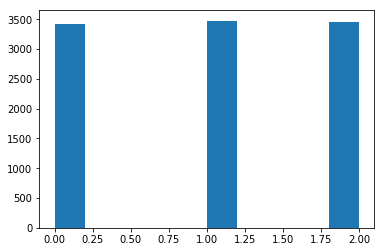

In [14]:
plt.hist(y_train)

In [17]:
import itertools
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
def generate_performance_results(actual, predicted):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(actual, predicted)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=["black", "white", "empty"], title='Confusion matrix, without normalization')
    
    print("\nPrecision, recall, F score and support (per class): ")
    print(precision_recall_fscore_support(actual, predicted))
    print("\nAccuracy")
    print(accuracy_score(actual, predicted))

## Baseline XGBoost model

G:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(189,)
Confusion matrix, without normalization
[[65  0 25]
 [ 0 95  0]
 [ 0  0  4]]
Precision, recall, F score and support (per class): 
(array([1.  , 1.  , 0.14]), array([0.72, 1.  , 1.  ]), array([0.84, 1.  , 0.24]), array([90, 95,  4], dtype=int64))
Accuracy
0.8677248677248677


G:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


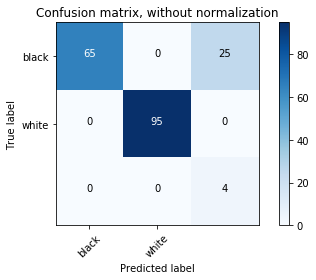

In [16]:
import xgboost as xgb

gbm = xgb.XGBClassifier(max_depth=5, n_estimators=1000, learning_rate=0.05, objective= 'multi:softmax', num_class=3).fit(X_train, y_train)
y_test_prections = gbm.predict(X_test)
y_train_predictions = gbm.predict(X_train)
print(y_test_prections.shape)

generate_performance_results(y_test, y_test_prections)